In [3]:
# Only run once!!
import os

os.chdir("../src/")

In [4]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler

import matplotlib as mpl
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, SGDRegressor, Ridge
import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, Problem
from cvxpy import norm as cvxnorm
from cvxpy import vec as cvxvec

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["text.usetex"] = True

matplotlib.rcParams.update(
    {
        "axes.titlesize": 8,
        "figure.titlesize": 10,  # was 10
        "legend.fontsize": 10,  # was 10
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
    }
)
run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SPINE_COLOR = "gray"


def format_axes(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    for spine in ["left", "bottom"]:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=SPINE_COLOR)
    return ax

In [3]:
task = "low_rank_cs"
run_id = "best_model"  # Change according to the id of the model you train
# run_id = "pretrained"
dr_model, dr_conf = get_model_from_run(os.path.join(run_dir, task, run_id))
dr_model.to("cuda:2")

TransformerModel(
  (_read_in): Linear(in_features=100, out_features=512, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 512)
    (wpe): Embedding(256, 512)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropo

In [4]:
dr_conf.model["n_dims"]

100

In [51]:
batch_size = 1280  # 1280 #1280 #conf.training.batch_size
n_dims = dr_conf.model["n_dims"]
n_points = dr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(dr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    dr_conf.training.task, n_dims, batch_size, **dr_conf.training.task_kwargs
)

In [52]:
seed = 42
torch.manual_seed(seed)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)
ys = task.evaluate(xs)

In [53]:
with torch.no_grad():
    transformer_preds = []
    eval_batch_size = 256
    for batch_idx in tqdm(range(0, batch_size, eval_batch_size)):
        transformer_preds.append(
            dr_model(
                xs[batch_idx : batch_idx + eval_batch_size].to("cuda:2"),
                ys[batch_idx : batch_idx + eval_batch_size].to("cuda:2"),
            ).cpu()
        )
    transformer_preds = torch.cat(transformer_preds, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
transformer_preds.shape

torch.Size([1280, 100])

In [55]:
metric = task.get_metric()
transformer_errors = metric(transformer_preds, ys).numpy().squeeze()

In [56]:
transformer_errors.mean(0)

array([116.242905  , 107.25094   , 104.83708   ,  97.264725  ,
        88.41844   ,  89.69736   ,  85.323326  ,  77.189445  ,
        76.24989   ,  67.076645  ,  50.196983  ,  53.302376  ,
        43.77218   ,  42.881584  ,  36.806767  ,  28.918741  ,
        28.21929   ,  22.15388   ,  18.124487  ,  21.004831  ,
        12.783358  ,  13.659147  ,  12.046022  ,   9.311749  ,
         8.715588  ,   7.744447  ,   6.840464  ,   6.8385797 ,
         6.086272  ,   4.890425  ,   5.0270176 ,   4.936494  ,
         4.43645   ,   3.8838146 ,   3.6304927 ,   3.140766  ,
         3.1471982 ,   2.9068537 ,   2.8173182 ,   2.4916787 ,
         2.1792378 ,   2.1220775 ,   1.9393984 ,   2.1613505 ,
         1.7513206 ,   1.7542095 ,   1.657397  ,   1.5837978 ,
         1.6166226 ,   1.4497083 ,   1.3089541 ,   1.233906  ,
         1.2568094 ,   1.2573919 ,   1.2369335 ,   0.9804977 ,
         1.0898216 ,   1.0242717 ,   0.9922191 ,   0.9156283 ,
         0.88958883,   0.89464486,   0.8699293 ,   0.98

In [57]:
lsq_preds = [np.zeros(xs.shape[0])]
for i in tqdm(range(1, xs.shape[1])):
    preds = []
    for batch_id in range(xs.shape[0]):
        preds.append(
            LinearRegression(fit_intercept=False)
            .fit(xs[batch_id, :i], ys[batch_id, :i])
            .predict(xs[batch_id, i : i + 1])[0]
        )
    preds = np.array(preds).squeeze()
    lsq_preds.append(preds)
lsq_preds = np.array(lsq_preds)
lsq_preds = torch.tensor(lsq_preds.T).float()

  0%|          | 0/99 [00:00<?, ?it/s]

In [58]:
lsq_errors = metric(lsq_preds, ys).numpy().squeeze()

In [59]:
mat_dim = int(np.sqrt(xs.shape[2]))
baseline_preds_batch = []
lnuc_norm_weights = []
for b in tqdm(range(xs.shape[0])):
    preds = [0]
    weights = []
    for t in range(xs.shape[1] - 1):
        w_star = Variable([mat_dim, mat_dim])
        obj = Minimize(cvxnorm(w_star, "nuc"))
        constraints = [
            ys[b, : t + 1].numpy()
            == (xs[b, : t + 1].numpy() @ cvxpy.reshape(w_star, mat_dim**2))
        ]
        prob = Problem(obj, constraints)
        result = prob.solve()
        pred = w_star.value.reshape(mat_dim**2) @ xs[b, t + 1].numpy()
        preds.append(pred)
        weights.append(w_star.value)
    baseline_preds_batch.append(preds)
    lnuc_norm_weights.append(weights)

  0%|          | 0/1280 [00:00<?, ?it/s]

In [60]:
baseline_preds_batch = torch.tensor(baseline_preds_batch).float()

In [61]:
lnuc_norm_weights = torch.tensor(lnuc_norm_weights).float()

In [62]:
lnuc_norm_weights.shape

torch.Size([1280, 99, 10, 10])

In [63]:
lnuc_errors = metric(baseline_preds_batch, ys).numpy().squeeze()

In [64]:
lnuc_errors.mean(0)

array([1.26196144e+02, 1.19717857e+02, 1.24973221e+02, 1.17875366e+02,
       1.10090561e+02, 1.12523270e+02, 1.23477280e+02, 1.06383118e+02,
       1.15371361e+02, 1.08257950e+02, 9.65656281e+01, 1.04355225e+02,
       9.87410965e+01, 9.47081375e+01, 8.87061615e+01, 8.30716629e+01,
       8.13038483e+01, 6.39608841e+01, 6.41543579e+01, 6.49384766e+01,
       4.79789963e+01, 4.88474045e+01, 3.94983368e+01, 3.55173416e+01,
       3.23863831e+01, 2.96777706e+01, 3.23796806e+01, 2.41933537e+01,
       1.90589848e+01, 1.42100811e+01, 1.26887035e+01, 9.43482399e+00,
       8.47163868e+00, 5.99658108e+00, 4.05618382e+00, 3.87834549e+00,
       2.56681561e+00, 1.99202847e+00, 2.23174143e+00, 8.61105442e-01,
       6.49246335e-01, 5.82970262e-01, 2.21924618e-01, 1.16418004e-01,
       5.08401766e-02, 4.77035865e-02, 1.87646858e-02, 2.73784939e-02,
       5.75250597e-04, 8.95445410e-04, 7.23415633e-06, 1.51128656e-08,
       1.39195206e-08, 1.08232072e-08, 1.10239622e-08, 8.74918804e-09,
      

In [65]:
# l2_norm_preds = []
# w_stars = []
# for b in tqdm(range(xs.shape[0])):
#     preds = [0]
#     for t in range(xs.shape[1] - 1):
#         w_star = Variable([n_dims, 1])
#         obj = Minimize(cvxnorm(w_star, 2))
#         constraints = [ys[b,:t+1].numpy()[:,np.newaxis] == (xs[b,:t+1].numpy() @ w_star)]
#         prob = Problem(obj, constraints)
#         result = prob.solve()
#         try:
#             pred = w_star.value[:,0] @ xs[b,t+1].numpy()
#         except:
#             pred = 0
# #         errors.append((pred - ys[b,t+1].numpy())**2)
#         w_stars.append(w_star.value)
#         preds.append(pred)
#     l2_norm_preds.append(preds)
# #     baseline_errors_batch.append(errors)
# # np.mean(errors)
# l2_norm_preds = torch.tensor(l2_norm_preds).float()

In [66]:
# l2_norm_errors = metric(l2_norm_preds, ys).numpy().squeeze()
# l2_norm_errors.shape

In [67]:
# l2_norm_errors.mean(axis = 0)

In [68]:
def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, seed):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        seed=seed,
        ci=90,
    )

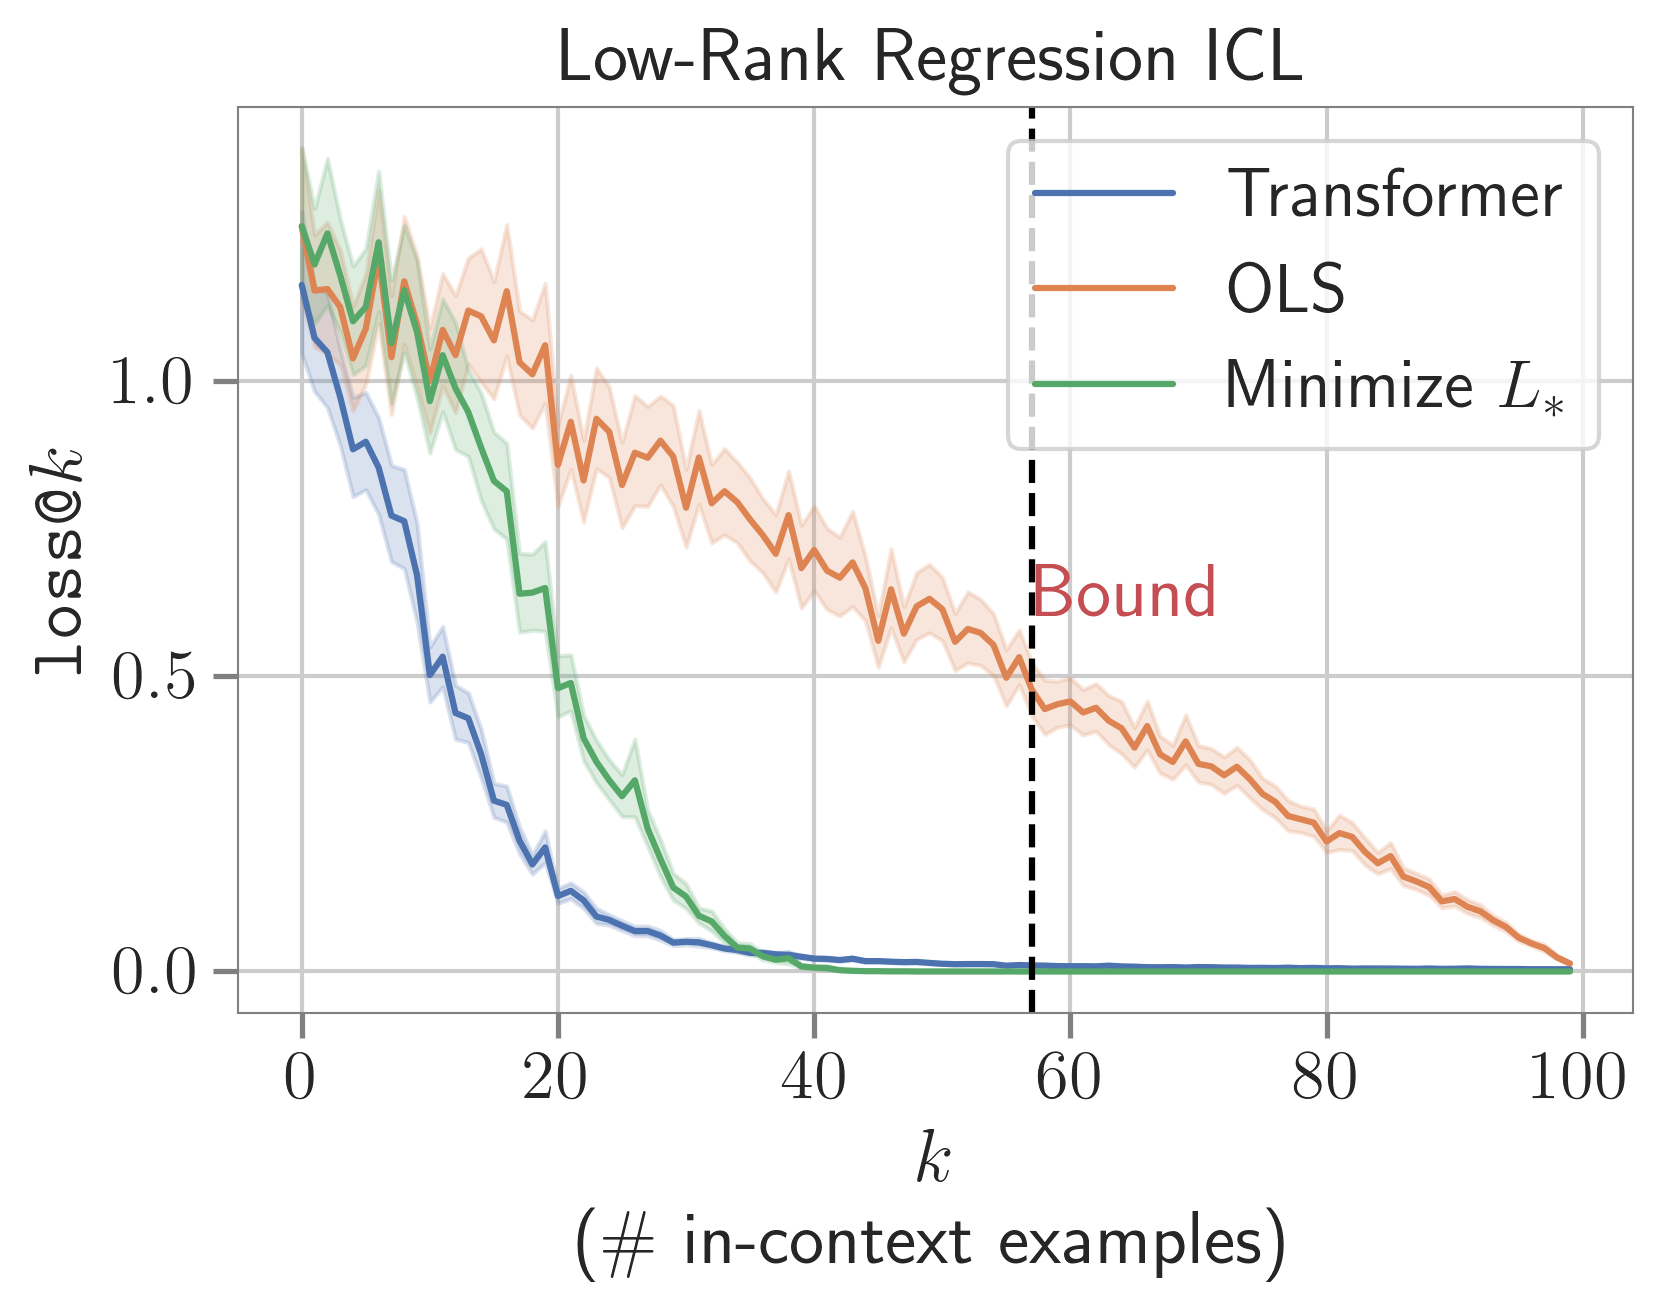

In [69]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)
import math

rank = dr_conf.training.task_kwargs["rank"]
m = math.sqrt(n_dims)
bound = 3 * rank * (2 * m - rank)
fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    transformer_errors / n_dims,
    n_points,
    offset=0,
    label="Transformer",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(lsq_errors / n_dims, n_points, offset=0, label="OLS", ax=ax, seed=seed)
lineplot_with_ci(
    lnuc_errors / n_dims, n_points, offset=0, label="Minimize $L_{*}$", ax=ax, seed=seed
)
# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("$\\texttt{loss@}k$")
ax.set_title("Low-Rank Regression ICL")
plt.axvline(bound, ls="--", color="black")
ax.annotate("Bound", xy=(bound + 0.25, 0.6), color="r", rotation=0)
format_axes(ax)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
plt.savefig("final_plots/low_rank_errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
def recover_weights_pv2(model, xs, ys, w_b, data_sampler):
    #     model.to("cuda:1")
    batch_size = xs.size(0)
    n_dims = w_b.size(1)

    x_probes = data_sampler.sample_xs(b_size=xs.shape[0], n_points=2 * xs.shape[-1] + 1)
    y_probes = []
    for i in tqdm(range(2 * xs.shape[-1] + 1)):
        x_prompt = torch.concat([xs, x_probes[:, i : i + 1, :]], axis=1)
        y_prompt = torch.concat([ys, torch.zeros(xs.shape[0], 1)], axis=1)
        #         with torch.no_grad():
        #             pred = model(x_prompt.to("cuda:0"), y_prompt.to("cuda:0")).cpu()

        eval_batch_size = 256
        pred = []
        with torch.no_grad():
            for batch_idx in range(0, batch_size, eval_batch_size):
                pred.append(
                    model(
                        x_prompt[batch_idx : batch_idx + eval_batch_size].to("cuda:2"),
                        y_prompt[batch_idx : batch_idx + eval_batch_size].to("cuda:2"),
                    ).cpu()
                )
        pred = torch.cat(pred, axis=0)

        y_probes.append(pred[:, -1:])

    y_probes = torch.cat(y_probes, axis=1)
    w_probed = []

    for batch in range(len(x_probes)):
        x, y = x_probes[batch], y_probes[batch]
        probe_model = LinearRegression(fit_intercept=False)
        probe_model.fit(x, y)
        w_probed.append(torch.tensor(probe_model.coef_[np.newaxis]).float())

    w_probed = torch.cat(w_probed, axis=0)
    error = ((w_probed - w_b[:, :, 0]) ** 2).mean(axis=1).mean()
    cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(w_probed, w_b[:, :, 0]).mean()

    return w_b, w_probed, error, cos_sim

In [17]:
seed = 42
torch.manual_seed(seed)
batch_size = 128  # 1280
n_points = dr_conf.training.curriculum.points.end
data_sampler = get_data_sampler(dr_conf.training.data, n_dims)
task_sampler = get_task_sampler(
    dr_conf.training.task, n_dims, batch_size, **dr_conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)
ys = task.evaluate(xs)

In [18]:
xs.shape

torch.Size([128, 100, 100])

In [42]:
w_probed_vecs = []
for n_points_i in tqdm(range(1, n_points)):
    _, w_probed, _, cos_sim = recover_weights_pv2(
        dr_model, xs[:, :n_points_i], ys[:, :n_points_i], task.w_b, data_sampler
    )
    w_probed_vecs.append(w_probed)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [43]:
w_probed_vecs[0].shape

torch.Size([128, 100])

In [24]:
# w_probed_old_vecs = []
# for n_points_i in tqdm(range(1, n_points)):
#     _, w_probed, _, cos_sim = recover_weights(dr_model, xs[:, :n_points_i], ys[:, :n_points_i], task.w_b)
#     w_probed_old_vecs.append(w_probed)

In [25]:
# ridge_preds = [np.zeros(xs.shape[0])]
lsq_weights = []
for i in tqdm(range(1, xs.shape[1])):
    weights = []
    for batch_id in range(xs.shape[0]):
        lsq_model = LinearRegression(fit_intercept=False)
        lsq_model.fit(xs[batch_id, :i], ys[batch_id, :i])
        weights.append(lsq_model.coef_)
    lsq_weights.append(weights)
lsq_weights = np.array(lsq_weights)
# ridge_weights = torch.tensor(ridge_weights).transpose(0,1).float()
lsq_weights = torch.tensor(lsq_weights).transpose(0, 1).float()

  0%|          | 0/99 [00:00<?, ?it/s]

In [29]:
cos_sims_trans_ols = []
cos_sims_trans_ridge = []
cos_sims_trans_gold = []
gold_weights = task.w_b
for n_points_i in tqdm(range(1, n_points)):
    trans_weight_vect = w_probed_vecs[n_points_i - 1].squeeze()
    ridge_weight_vect = ridge_weights[:, n_points_i - 1].squeeze()
    ols_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()

    cos_sims_trans_ols.append(
        torch.nn.CosineSimilarity(dim=1, eps=1e-6)(trans_weight_vect, ols_weight_vect)
    )
    cos_sims_trans_ridge.append(
        torch.nn.CosineSimilarity(dim=1, eps=1e-6)(trans_weight_vect, ridge_weight_vect)
    )
    cos_sims_trans_gold.append(
        torch.nn.CosineSimilarity(dim=1, eps=1e-6)(
            trans_weight_vect, gold_weights.squeeze()
        )
    )

  0%|          | 0/40 [00:00<?, ?it/s]

In [30]:
cos_sims_trans_ridge = torch.vstack(cos_sims_trans_ridge).transpose(0, 1)
cos_sims_trans_gold = torch.vstack(cos_sims_trans_gold).transpose(0, 1)
cos_sims_trans_ols = torch.vstack(cos_sims_trans_ols).transpose(0, 1)

In [44]:
mse_trans_lsq = []
mse_trans_nuc = []
mse_trans_gold = []
mse_nuc_gold = []
gold_weights = task.w_b
for n_points_i in tqdm(range(1, n_points)):
    trans_weight_vect = w_probed_vecs[n_points_i - 1].squeeze()
    lsq_weight_vect = lsq_weights[:, n_points_i - 1].squeeze()
    lnuc_weight_vect = torch.tensor(
        lnuc_norm_weights[:, n_points_i - 1].squeeze().view(-1, n_dims)
    ).float()

    mse_trans_lsq.append(((trans_weight_vect - lsq_weight_vect) ** 2).mean(axis=-1))
    mse_trans_nuc.append(((trans_weight_vect - lnuc_weight_vect) ** 2).mean(axis=-1))
    mse_trans_gold.append(
        ((trans_weight_vect - gold_weights.squeeze()) ** 2).mean(axis=-1)
    )
    mse_nuc_gold.append(
        ((lnuc_weight_vect - gold_weights.squeeze()) ** 2).mean(axis=-1)
    )

  0%|          | 0/99 [00:00<?, ?it/s]

/tmp/ipykernel_11794/1364258280.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lnuc_weight_vect = torch.tensor(lnuc_norm_weights[:, n_points_i - 1].squeeze().view(-1, n_dims)).float()


In [45]:
mse_trans_lsq = torch.vstack(mse_trans_lsq).transpose(0, 1)
mse_trans_nuc = torch.vstack(mse_trans_nuc).transpose(0, 1)
mse_trans_gold = torch.vstack(mse_trans_gold).transpose(0, 1)
mse_nuc_gold = torch.vstack(mse_nuc_gold).transpose(0, 1)

In [46]:
mse_trans_lsq.shape

torch.Size([128, 99])

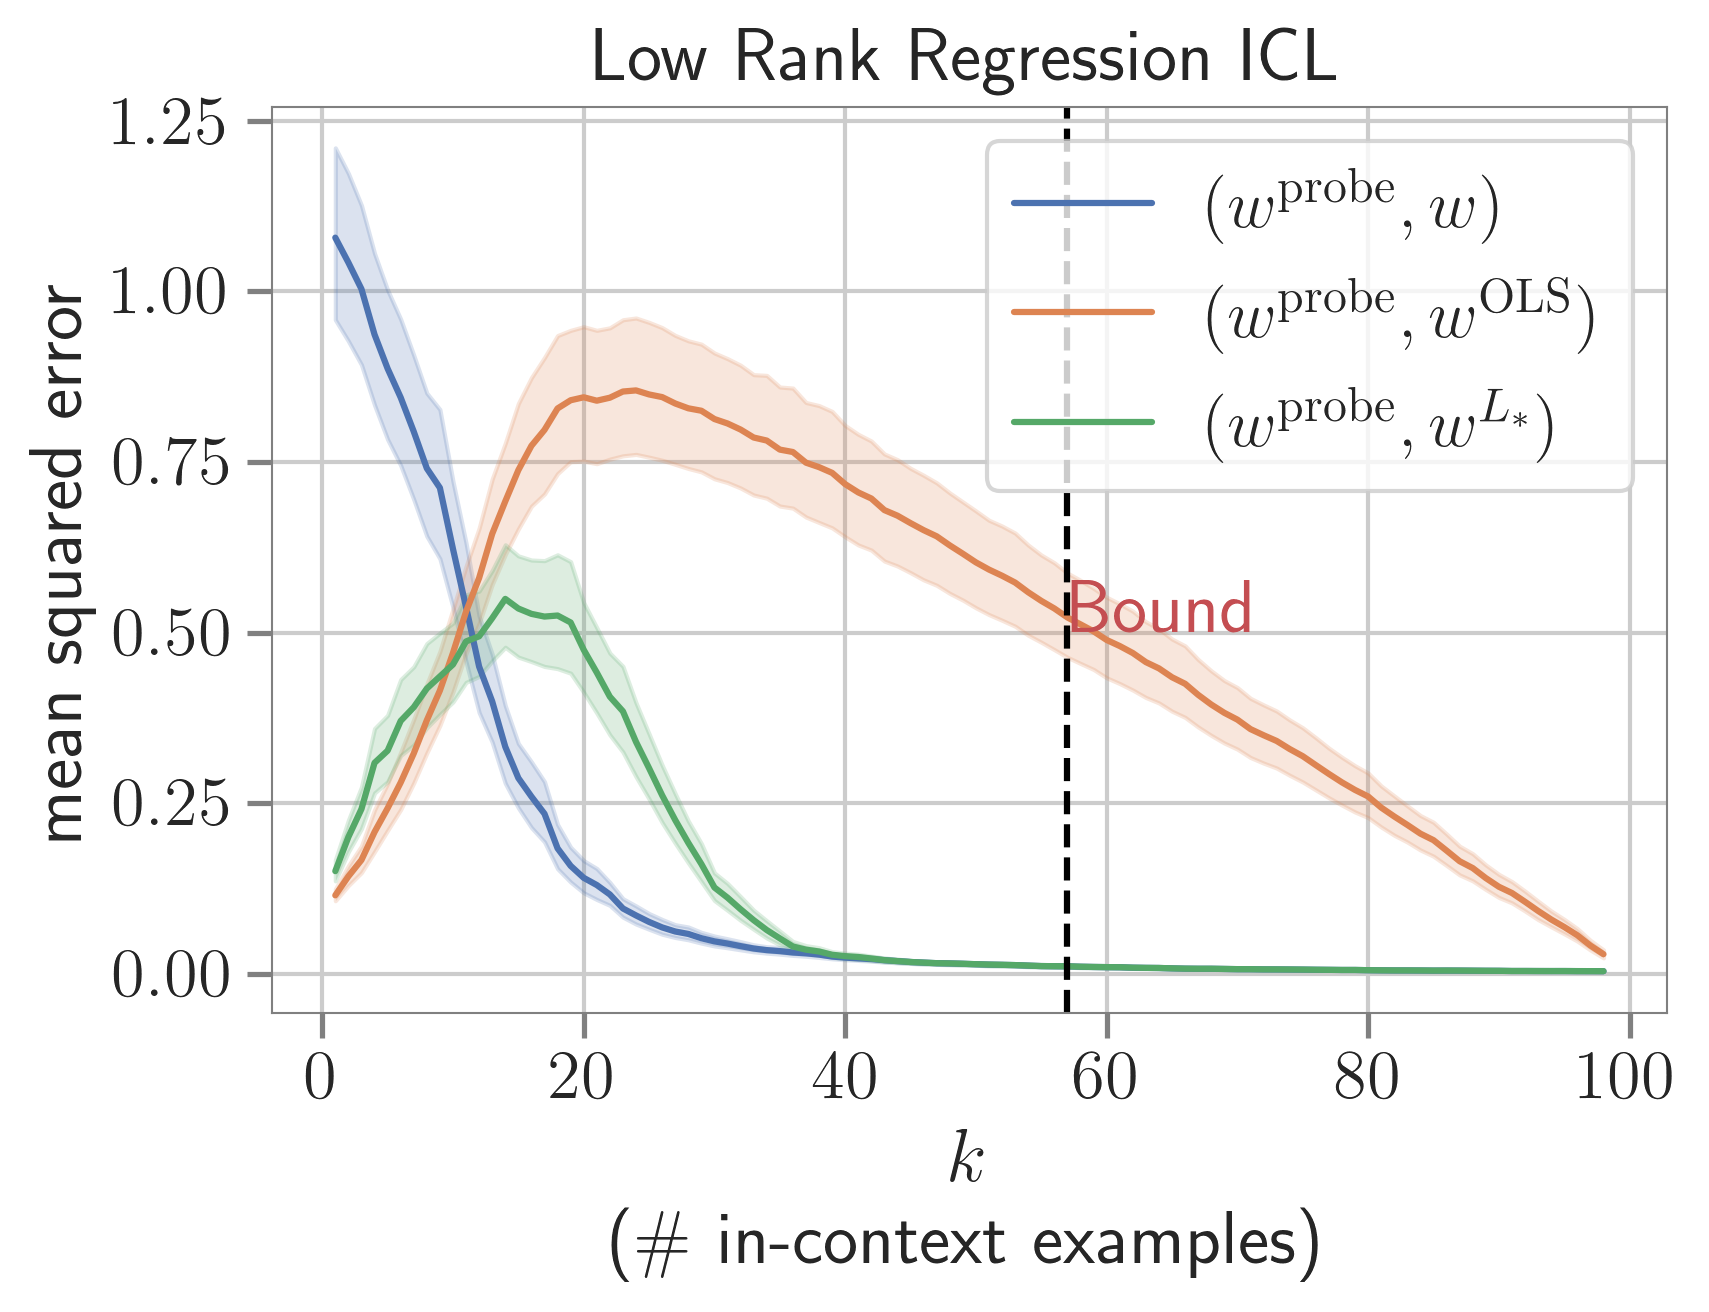

In [49]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

import math

rank = dr_conf.training.task_kwargs["rank"]
m = math.sqrt(n_dims)
bound = 3 * rank * (2 * m - rank)

fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    mse_trans_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^\mathrm{probe}, w)$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    mse_trans_lsq[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^\mathrm{probe}, w^\mathrm{OLS})$",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    mse_trans_nuc[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^\mathrm{probe}, w^{L_{*}})$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(mse_nuc_gold[:,:-1], n_points - 1, offset = 1, label="$(w, w^{L_{*}})$", ax=ax, seed=seed)

# lineplot_with_ci(cos_sims_trans_old_ridge[:,:-1], n_points - 1, offset = 1, label="$(w^\mathrm{probe}_{old}, w^{PME})$", ax=ax, seed=seed)
# lineplot_with_ci(cos_sims_trans_old_ridge[:,:-1], n_points - 1, offset = 1, label="$(w^\mathrm{probe}_{old}, w^{PME})$", ax=ax, seed=seed)


# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("mean squared error")
ax.set_title("Low Rank Regression ICL")
format_axes(ax)
plt.axvline(bound, ls="--", color="black")
ax.annotate("Bound", xy=(bound + 0.25, 0.5), color="r", rotation=0)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
plt.savefig("final_plots/low_rank_probing_mse.pdf", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_8917/1129022802.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.lineplot(data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset = offset),
/tmp/ipykernel_8917/1129022802.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.lineplot(data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset = offset),
/tmp/ipykernel_8917/1129022802.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  sns.lineplot(data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset = offset),


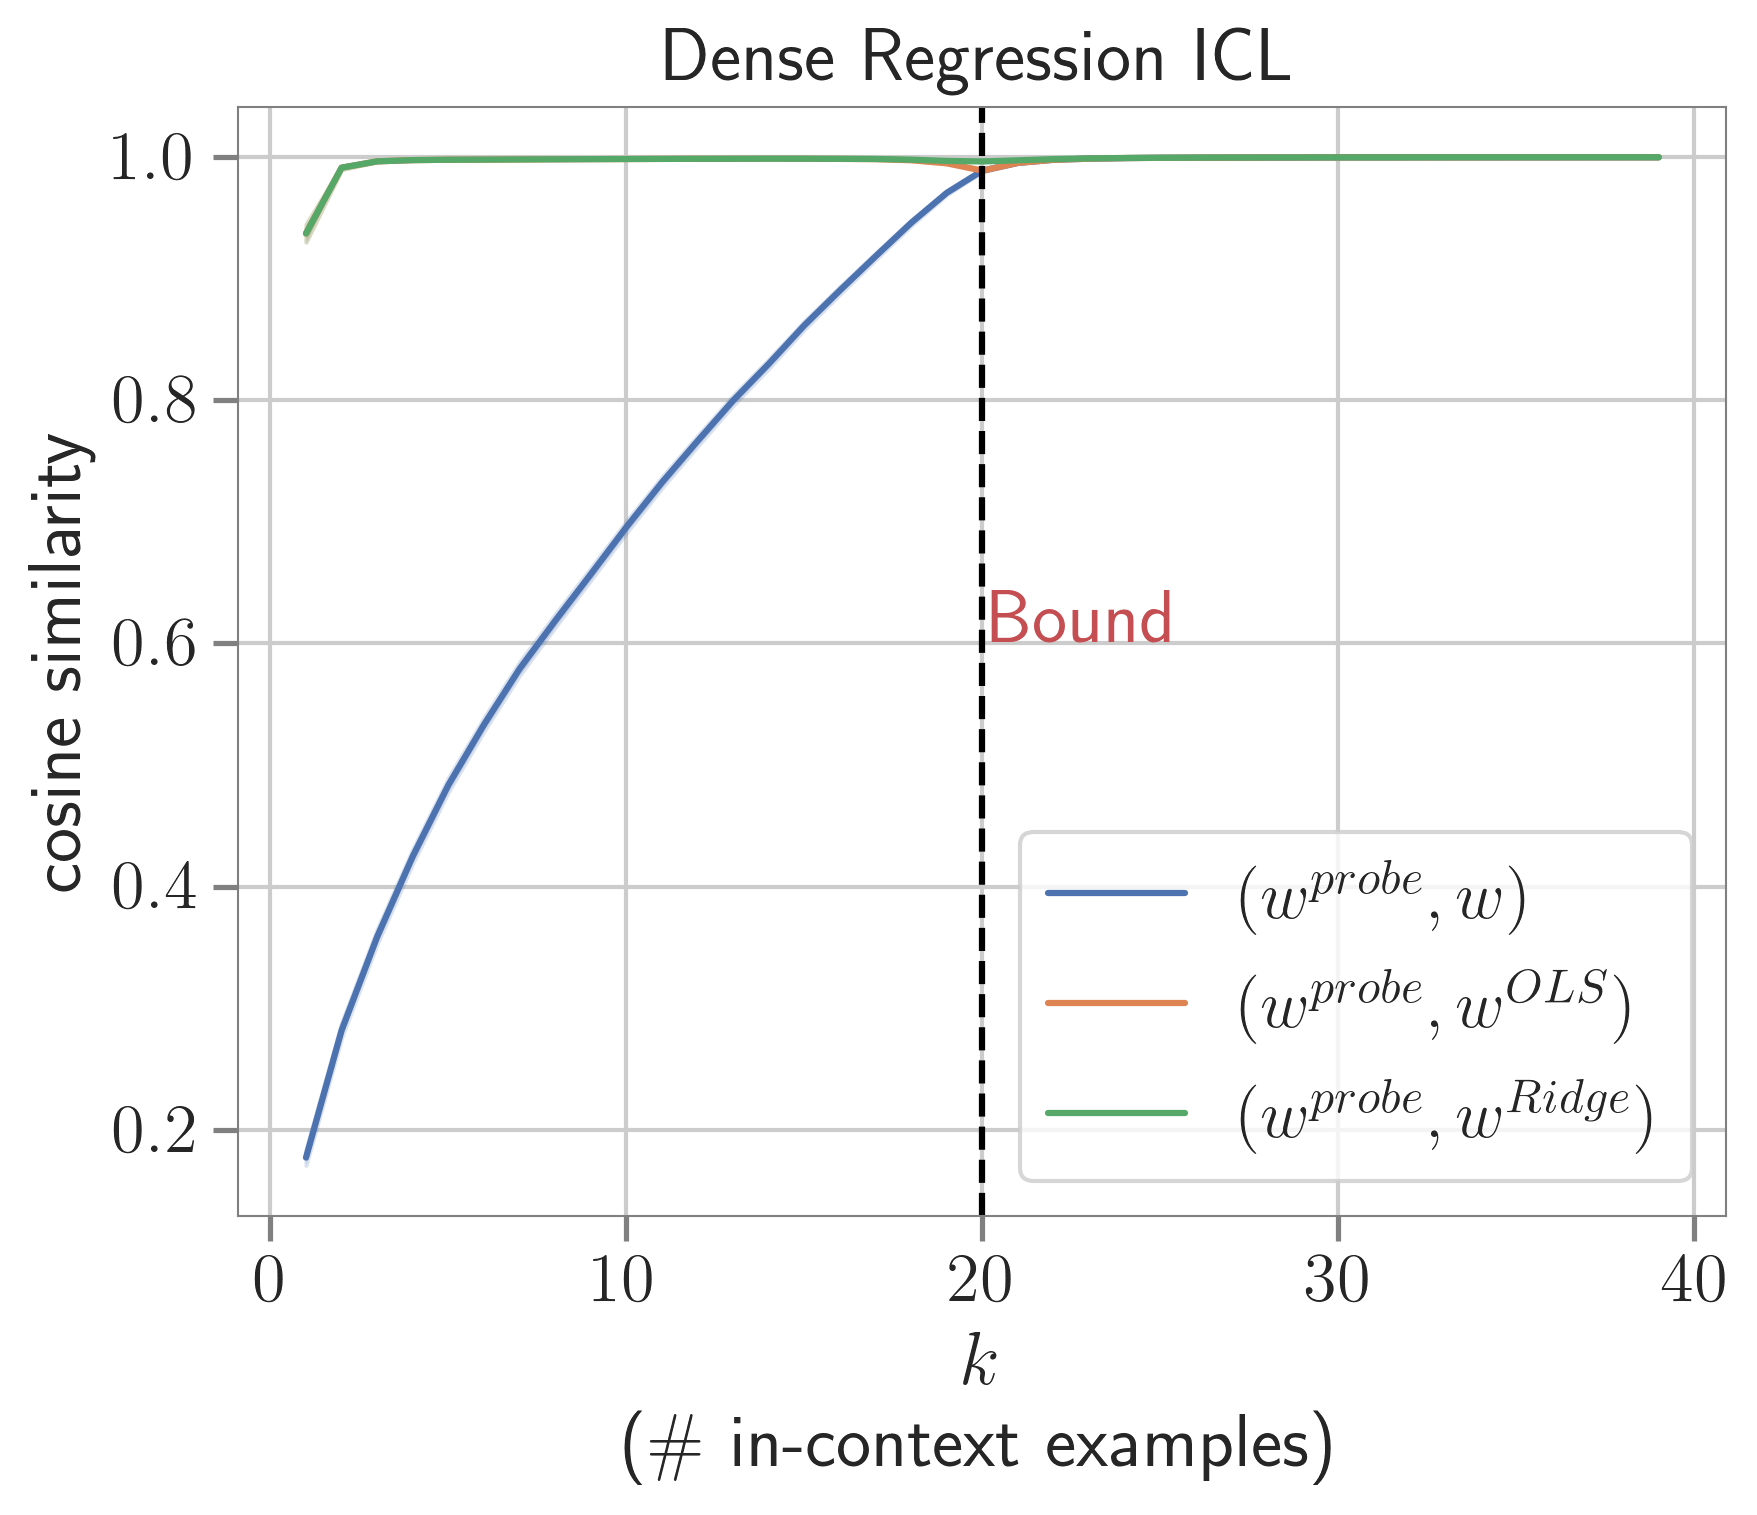

In [33]:
sns.set(style="whitegrid", font_scale=1.5)
# latexify(4, 3)

fig, ax = plt.subplots()
# ax.plot(list(range(n_points)), transformer_pe_errors.mean(axis=0), label = "With Position Encodings")
# ax.plot(list(range(n_points)), transformer_no_pe_errors.mean(axis=0), label = "Without Position Encodings")
lineplot_with_ci(
    cos_sims_trans_gold[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{probe}, w)$",
    ax=ax,
    seed=seed,
)
# lineplot_with_ci(lsq_errors, n_points, label="Least Squares", ax=ax, seed=seed)
lineplot_with_ci(
    cos_sims_trans_ols[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{probe}, w^{OLS})$",
    ax=ax,
    seed=seed,
)
lineplot_with_ci(
    cos_sims_trans_ridge[:, :-1],
    n_points - 1,
    offset=1,
    label="$(w^{probe}, w^{L_{*}})$",
    ax=ax,
    seed=seed,
)

# lineplot_with_ci(cos_sims_trans_old_ridge[:,:-1], n_points - 1, offset = 1, label="$(w^{probe}_{old}, w^{PME})$", ax=ax, seed=seed)
# lineplot_with_ci(cos_sims_trans_old_ridge[:,:-1], n_points - 1, offset = 1, label="$(w^{probe}_{old}, w^{PME})$", ax=ax, seed=seed)


# lineplot_with_ci(l2_norm_errors, n_points, label="L-2 Norm Min", ax=ax, seed=seed)
ax.set_xlabel("$k$\n(\# in-context examples)")
ax.set_ylabel("cosine similarity")
ax.set_title("Dense Regression ICL")
plt.axvline(bound, ls="--", color="black")
ax.annotate("Bound", xy=(bound + 0.25, 0.6), color="r", rotation=0)
format_axes(ax)
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.legend()
# plt.savefig("final_plots/lr_probing.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

In [48]:
def get_ridge_weights(xs, ys):
    # Minimize inf norm with WX=y as constraints
    w_ridge = []
    for b in range(xs.shape[0]):
        ridge = Ridge(fit_intercept=False, alpha=1e-2)
        ridge.fit(xs[b], ys[b])
        w_ridge.append(ridge.coef_)
    w_ridge = np.concatenate(w_ridge, axis=0)

    return w_ridge

In [49]:
n_points_ls = list(range(2, 21, 2))
seeds = [1, 11, 22, 33, 44]
batch_size = 1
torch.manual_seed(42)
task_sampler = get_task_sampler(
    dr_conf.training.task, n_dims, batch_size, **dr_conf.training.task_kwargs
)

task = task_sampler()

w_ridge_seed_wise = np.zeros((len(n_points_ls), len(seeds), n_dims))
w_prompt_seed_wise = np.zeros((len(n_points_ls), len(seeds), n_dims))

for np_idx, n_points in tqdm(enumerate(n_points_ls), total=len(n_points_ls)):
    for s_idx, seed in enumerate(seeds):
        torch.manual_seed(seed)
        xs = data_sampler.sample_xs(b_size=batch_size, n_points=n_points)
        ys = task.evaluate(xs)
        _, w_probe, error, cos_sim = recover_weights_pv2(
            dr_model, xs, ys, task.w_b, data_sampler
        )

        w_ridge = get_ridge_weights(xs, ys)

        w_ridge_seed_wise[np_idx, s_idx] = w_ridge.squeeze()
        w_prompt_seed_wise[np_idx, s_idx] = w_probe.squeeze().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
w_prompt_seed_wise

array([[[ 4.01012212e-01,  2.00409651e-01,  9.54791903e-02,
          4.09389883e-01, -1.72801897e-01,  3.26655433e-02,
          3.77066255e-01,  3.19899768e-01,  1.46595463e-01,
         -1.56170443e-01,  2.06761539e-01,  1.15586668e-01,
          2.22033024e-01, -2.73801565e-01,  1.55724492e-03,
          2.00576093e-02,  2.90793926e-02,  3.60766739e-01,
         -1.55252904e-01, -1.66835502e-01],
        [ 1.16635546e-01, -4.90999371e-02, -1.14057526e-01,
         -1.37461841e-01,  1.38439029e-01,  2.23390967e-01,
          1.39085501e-01,  1.43440858e-01,  1.82881683e-01,
          2.16758668e-01, -4.13845897e-01,  1.65679336e-01,
         -1.79227605e-01, -2.82617688e-01,  2.71384597e-01,
          1.01924405e-01, -4.68529388e-02, -4.64370370e-01,
          2.98823923e-01,  4.04510438e-01],
        [ 5.89587212e-01, -1.07816122e-01,  4.51639563e-01,
         -4.13921058e-01,  4.33097303e-01,  1.05203174e-01,
          1.09325600e+00,  2.77734250e-01, -5.57275414e-01,
         -6.

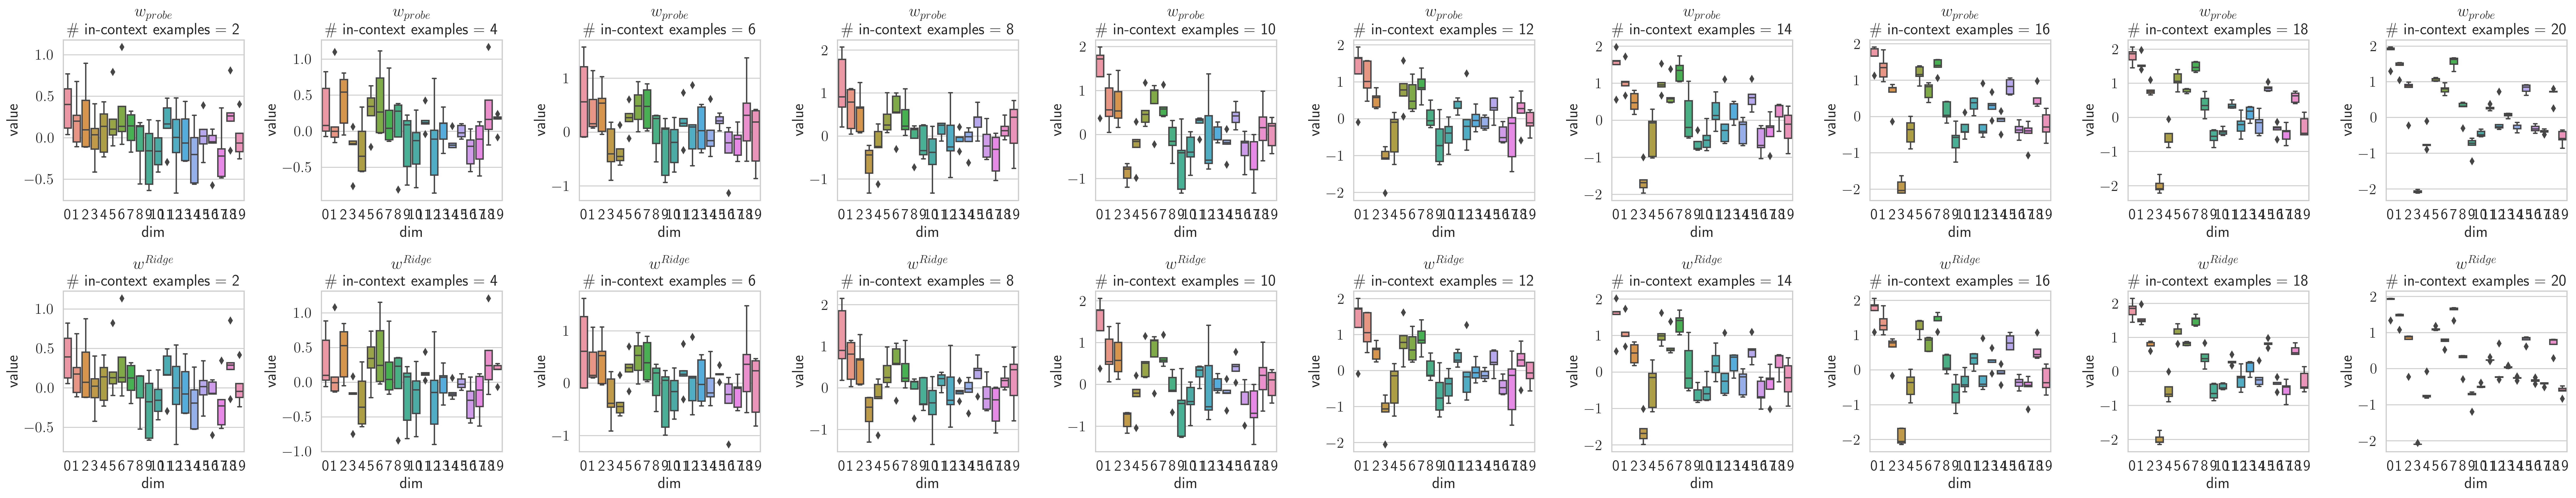

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=len(n_points_ls), figsize=(40, 8))

for np_idx, n_points in enumerate(n_points_ls):
    w_df = pd.DataFrame(w_prompt_seed_wise[np_idx]).transpose()
    w_df.columns = [f"seed_{seeds[int(cid)]}" for cid in w_df.columns]
    w_df = w_df.reset_index()
    w_df.columns = ["dim"] + list(w_df.columns)[1:]
    w_df = w_df.melt(
        id_vars="dim", value_vars=[f"seed_{seed}" for seed in seeds], var_name="seed"
    )
    sns.boxplot(data=w_df, x="dim", y="value", ax=axs[0][np_idx])
    axs[0][np_idx].set_title("$w_{probe}$" + f"\n\# in-context examples = {n_points}")

    w_df = pd.DataFrame(w_ridge_seed_wise[np_idx]).transpose()
    w_df.columns = [f"seed_{seeds[int(cid)]}" for cid in w_df.columns]
    w_df = w_df.reset_index()
    w_df.columns = ["dim"] + list(w_df.columns)[1:]
    w_df = w_df.melt(
        id_vars="dim", value_vars=[f"seed_{seed}" for seed in seeds], var_name="seed"
    )
    sns.boxplot(data=w_df, x="dim", y="value", ax=axs[1][np_idx])
    axs[1][np_idx].set_title("$w^{Ridge}$" + f"\n\# in-context examples = {n_points}")
fig.tight_layout()
plt.savefig("lr_probing_stability.pdf", bbox_inches="tight", dpi=300)

In [60]:
w_ridge_seed_wise[0] @ w_ridge_seed_wise[0].T

array([[ 1.09731752, -0.23909512,  0.64572852,  0.17226041, -0.2728437 ],
       [-0.23909512,  1.13065324, -0.02624707,  0.19369009,  0.51579091],
       [ 0.64572852, -0.02624707,  4.1561108 ,  0.17705363,  1.48312813],
       [ 0.17226041,  0.19369009,  0.17705363,  0.60413481,  0.07644041],
       [-0.2728437 ,  0.51579091,  1.48312813,  0.07644041,  5.73644178]])

In [61]:
w_ridge_seed_wise[1] @ w_ridge_seed_wise[1].T

array([[ 2.88118385,  0.31739848,  1.3995361 , -0.23911604,  0.43076276],
       [ 0.31739848,  1.78790499,  0.63009306,  0.16628516,  1.59477215],
       [ 1.3995361 ,  0.63009306,  6.2993337 , -0.11336506,  1.37336463],
       [-0.23911604,  0.16628516, -0.11336506,  0.22570792,  0.01216506],
       [ 0.43076276,  1.59477215,  1.37336463,  0.01216506,  6.8136801 ]])

In [62]:
w_ridge_seed_wise[-1] @ w_ridge_seed_wise[-1].T

array([[19.33507703, 19.09527248, 19.32911959, 14.88981816, 19.25269778],
       [19.09527248, 18.89426395, 19.0853525 , 14.69683605, 19.00812208],
       [19.32911959, 19.0853525 , 19.32775087, 14.9022015 , 19.25010416],
       [14.88981816, 14.69683605, 14.9022015 , 14.82970259, 14.74906867],
       [19.25269778, 19.00812208, 19.25010416, 14.74906867, 19.23221545]])